# Testing cancelation of SRG transformations in momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ February 9, 2023

The SRG transformations are unitary and therefore satisfy the condition<br>

$$
\begin{align}
U^\dagger U &= I + \frac{1}{4} \sum_{\mathbf{k}, \mathbf{k'}, \mathbf{K}} \bigl[
    \delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'})
    + \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
\bigr]
a^\dagger_{\frac{\mathbf{K}}{2}+\mathbf{k}} a^\dagger_{\frac{\mathbf{K}}{2}-\mathbf{k}}
a_{\frac{\mathbf{K}}{2}-\mathbf{k'}} a_{\frac{\mathbf{K}}{2}+\mathbf{k'}} \\
&= I
.
\end{align}
$$<br>

This implies that<br>

$$
\delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
+ \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
= 0
.
$$<br>

In partial waves this looks like<br>

$$
\delta U_{LL'}(k,k') + \delta U^\dagger_{LL'}(k,k') + \frac{2}{\pi} \sum_{L''} \int dk'' k''^2
    \delta U_{LL''}(k,k'') \delta U^\dagger_{L''L'}(k'',k')
= 0
,
$$<br>
given partial wave channel quantum numbers $J$, $S$, and $T$.<br>

_Last update:_ April 3, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import RectBivariateSpline
from scipy.special import sph_harm
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, label_ticks, set_rc_parameters
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix,
    attach_weights_to_matrix
)
from scripts.potentials import Potential
from scripts.srg import SRG
from scripts.tools import coupled_channel, replace_periods

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Check cancelation of matrix elements in partial-wave basis

In [4]:
def partial_wave_cancelation(kvnn, channel, kmax, kmid, ntot, generator, lamb):
    """Check the cancelation of the \delta U's (see the last equation above)."""

    srg = SRG(kvnn, channel, kmax, kmid, ntot, generator)
    k_array, k_weights = srg.load_mesh()
    
    # SRG transformation matrix with integration weights attached
    U_matrix = srg.load_srg_transformation(lamb)
    
    # Identity matrix
    I_matrix = np.eye(len(U_matrix))

    # \delta U and \delta U^\dagger matrices
    delta_U = U_matrix - I_matrix
    delta_U_dag = (U_matrix - I_matrix).T
    
    if srg.coupled_channel_bool:
        
        matrix = (
            delta_U[:ntot, :ntot] + delta_U_dag[:ntot, :ntot]
            + delta_U[:ntot, :ntot] @ delta_U_dag[:ntot, :ntot]
            + delta_U[:ntot, ntot:] @ delta_U_dag[ntot:, :ntot]
        )
        
    else:
        
        matrix = delta_U + delta_U_dag + delta_U @ delta_U_dag
    
    # Matrix with integration weights
    print(matrix)
    print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
    
    # Matrix without integration weights
    matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)
    print("Norm of matrix without integration weights = "
          f"{la.norm(matrix_no_weights):.5f}.\n")
    
    return k_array, matrix_no_weights

In [5]:
def plot_delU_sum(
        k_array, matrix_no_weights, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,4.0),
        xlabel_size=16, ylabel_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # We don't need the second output since it'll be the same as the first
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
    k_array_dense, _, matrix_dense = interpolate_matrix(
        k_array, k_array, matrix_no_weights, k_max, k_max)

    # --- Plot --- #
    c = ax.contourf(k_array_dense, k_array_dense, matrix_dense, levels,
                    cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title(r"[fm$^3$]", fontsize=16, pad=15)

In [6]:
# Default settings for SMS N4LO 450 MeV
kvnn = 111
kmax, kmid, ntot = 15.0, 3.0, 120

# Default settings for AV18
# kvnn = 6
# kmax, kmid, ntot = 30.0, 4.0, 120

generator = 'Wegner'

[[ 1.15976225e-10 -1.48527343e-14 -4.59159924e-14 ... -1.08053810e-17
  -2.72343779e-17 -2.71168708e-17]
 [-1.48527343e-14  7.47756663e-09 -3.62231242e-13 ... -8.76870196e-17
  -2.19083411e-16 -2.08920077e-16]
 [-4.59159924e-14 -3.62231242e-13  7.06555109e-08 ... -2.78020002e-16
  -6.76269994e-16 -6.56060372e-16]
 ...
 [-1.08053810e-17 -8.76870196e-17 -2.78020002e-16 ...  9.55363327e-08
   5.09022211e-11  8.29601416e-13]
 [-2.72343779e-17 -2.19083411e-16 -6.76269994e-16 ...  5.09022211e-11
  -9.91986965e-08 -5.54948240e-11]
 [-2.71168708e-17 -2.08920077e-16 -6.56060372e-16 ...  8.29601416e-13
  -5.54948240e-11  7.27490102e-08]]
Norm of matrix with integration weights = 0.00000.

Norm of matrix without integration weights = 0.07453.



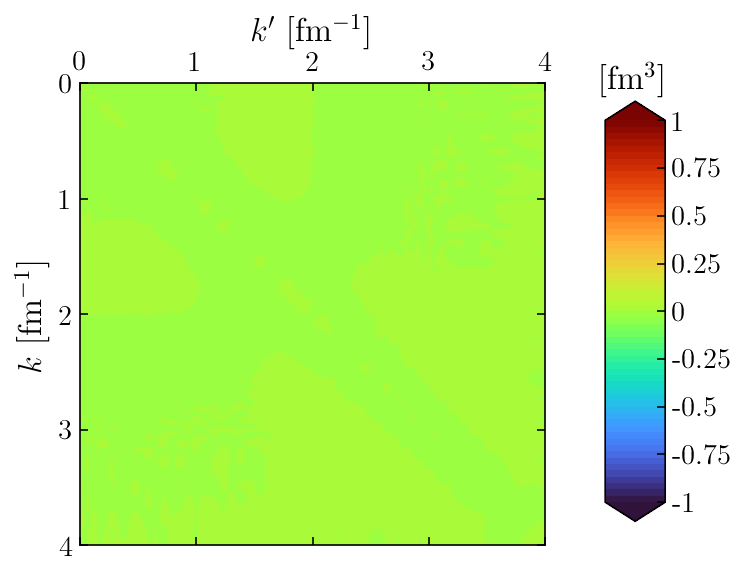

In [7]:
# SMS N4LO 450 MeV in the 1S0 channel at \lambda = 1.35 fm^-1
k_array, matrix_no_weights = partial_wave_cancelation(kvnn, '1S0', kmax, kmid,
                                                      ntot, generator, 1.35)
plot_delU_sum(k_array, matrix_no_weights)

[[ 8.81809484e-10 -8.09470219e-14 -2.47510574e-13 ... -7.04172223e-17
  -3.32218918e-17 -1.45618860e-18]
 [-8.09470219e-14  5.68554840e-08 -1.99430836e-12 ... -5.61997902e-16
  -2.65367677e-16 -8.84551811e-18]
 [-2.47510574e-13 -1.99430836e-12 -6.27320014e-08 ... -1.68166456e-15
  -7.94156613e-16 -3.17844255e-17]
 ...
 [-7.04172223e-17 -5.61997902e-16 -1.68166456e-15 ... -8.74515805e-08
  -3.43043774e-11 -2.99628478e-11]
 [-3.32218918e-17 -2.65367677e-16 -7.94156613e-16 ... -3.43043774e-11
   6.15780379e-08 -1.02427825e-10]
 [-1.45618860e-18 -8.84551811e-18 -3.17844255e-17 ... -2.99628478e-11
  -1.02427825e-10  1.54671109e-08]]
Norm of matrix with integration weights = 0.00000.

Norm of matrix without integration weights = 0.46071.



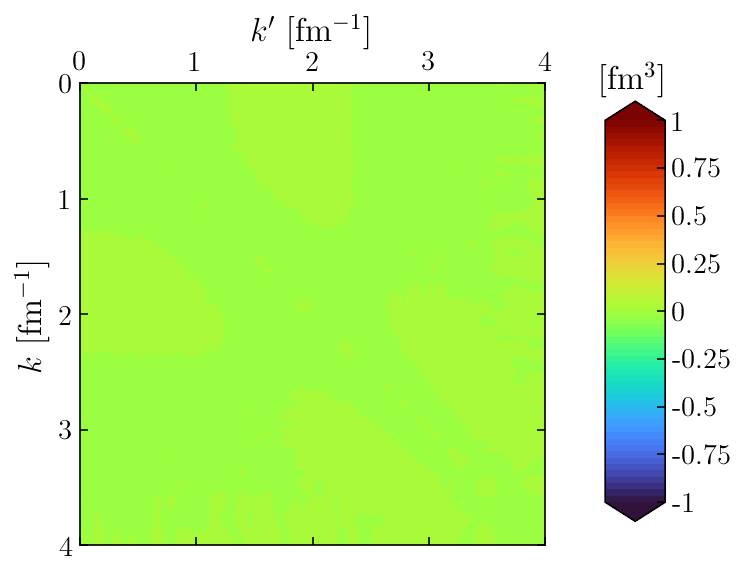

In [8]:
# SMS N4LO 450 MeV in the 3S1-3D1 channel at \lambda = 1.35 fm^-1
k_array, matrix_no_weights = partial_wave_cancelation(kvnn, '3S1', kmax, kmid,
                                                      ntot, generator, 1.35)
plot_delU_sum(k_array, matrix_no_weights)

## Check cancelation of matrix elements in plane-wave basis

The plane-wave matrix elements of $\delta U$ can be expressed in terms of the partial wave matrix elements (with many sums and Clesbch-Gordan coefficients):</br>

$$
\begin{align}
\delta U(\mathbf{k},\mathbf{k'}) &\equiv \langle \mathbf{k} \sigma_1 \tau_1 \sigma_2 \tau_2 \vert \delta U \vert \mathbf{k'} \sigma_3 \tau_3 \sigma_4 \tau_4 \rangle \\
&= \frac{1}{2} \frac{2}{\pi} \sum_{S M_S M_S'} \sum_{T M_T} \sum_{L M_L} \sum_{L' M_L'} \sum_{J M_J}
    \langle \sigma_1 \sigma_2 \vert S M_S \rangle \langle S M_S' \vert \sigma_3 \sigma_4 \rangle
    \langle \tau_1 \tau_2 \vert T M_T \rangle \langle T M_T \vert \tau_3 \tau_4 \rangle
    \langle L M_L S M_S \vert J M_J \rangle \\
    &\qquad\times \langle J M_J \vert L' M_L' S M_S' \rangle
    \bigl( 1-(-1)^{L+S+T} \bigr) \bigl( 1-(-1)^{L'+S+T} \bigr)
    Y_{L M_L}(\Omega_{\mathbf{k}}) Y^*_{L' M_L'}(\Omega_{\mathbf{k'}})
    \langle k J (L S) T \vert \delta U \vert k' J (L' S) T \rangle
\end{align}
$$

The plane-wave cancelation equation (second equation) from the notebook header can be written in terms of the partial-wave matrix elements:</br>

$$
\begin{align}
0 &= \delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
    + \frac{1}{2} \sum_{\mathbf{q}} \delta U(\mathbf{k},\mathbf{q}) \delta U^\dagger(\mathbf{q},\mathbf{k'}) \\
&= \Bigl[
    \frac{1}{2} \frac{2}{\pi} \sum_{S M_S M_S'} \sum_{T M_T} \sum_{L M_L} \sum_{L' M_L'} \sum_{J M_J}
    \langle \sigma_1 \sigma_2 \vert S M_S \rangle \langle S M_S' \vert \sigma_3 \sigma_4 \rangle
    \langle \tau_1 \tau_2 \vert T M_T \rangle \langle T M_T \vert \tau_3 \tau_4 \rangle
    \langle L M_L S M_S \vert J M_J \rangle \langle J M_J \vert L' M_L' S M_S' \rangle \\
    &\qquad\times \bigl( 1-(-1)^{L+S+T} \bigr) \bigl( 1-(-1)^{L'+S+T} \bigr)
    Y_{L M_L}(\Omega_{\mathbf{k}}) Y^*_{L' M_L'}(\Omega_{\mathbf{k'}})
    \bigl(
        \langle k J (L S) T \vert \delta U \vert k' J (L' S) T \rangle
        + \langle k J (L S) T \vert \delta U^\dagger \vert k' J (L' S) T \rangle
    \bigr) \\
    &\quad+ \frac{1}{2} (\frac{1}{2} \frac{2}{\pi})^2 \sum_{\sigma \sigma'} \sum_{\tau \tau'}
    \sum_{S M_S M_S''} \sum_{T M_T} \sum_{L M_L} \sum_{L'' M_L''} \sum_{J M_J}
    \sum_{S' M_S' M_S'''} \sum_{T' M_T'} \sum_{L''' M_L'''} \sum_{L' M_L'} \sum_{J' M_J'}
    \int_0^\infty dq q^2 \int d\Omega_{\mathbf{q}} \\
        &\qquad\times \langle \sigma_1 \sigma_2 \vert S M_S \rangle \langle S M_S'' \vert \sigma \sigma' \rangle
        \langle \sigma \sigma' \vert S' M_S' \rangle \langle S' M_S''' \vert \sigma_3 \sigma_4 \rangle
        \langle \tau_1 \tau_2 \vert T M_T \rangle \langle T M_T \vert \tau \tau' \rangle
        \langle \tau \tau' \vert T' M_T' \rangle \langle T' M_T' \vert \tau_3 \tau_4 \rangle \\
        &\qquad\times \langle L M_L S M_S \vert J M_J \rangle \langle J M_J \vert L'' M_L'' S M_S'' \rangle
        \langle L''' M_L''' S' M_S''' \vert J' M_J' \rangle \langle J' M_J' \vert L' M_L' S' M_S' \rangle \\
        &\qquad\times \bigl( 1-(-1)^{L+S+T} \bigr) \bigl( 1-(-1)^{L''+S+T} \bigr)
        \bigl( 1-(-1)^{L'''+S'+T'} \bigr) \bigl( 1-(-1)^{L'+S'+T'} \bigr)
        Y_{L M_L}(\Omega_{\mathbf{k}}) Y^*_{L'' M_L''}(\Omega_{\mathbf{q}})
        Y_{L''' M_L'''}(\Omega_{\mathbf{q}}) Y^*_{L' M_L'}(\Omega_{\mathbf{k'}}) \\
        &\qquad\times \langle k J (L S) T \vert \delta U \vert q J (L'' S) T \rangle
        \langle q J' (L''' S') T' \vert \delta U \vert k' J' (L' S') T' \rangle
\Bigr].
\end{align}
$$</br>

To test the cancelation, we will fix the single-particle momenta $\mathbf{k}$ and $\mathbf{k'}$, the spin projections $\sigma_i$, and the isospin projections $\tau_i$.
In this way, we will output a number (that should be zero).

In [9]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for all combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)

    for j_1 in j_array:
        for m_1 in np.arange(-j_1, j_1+1, 1):
            for j_2 in j_array:
                for m_2 in np.arange(-j_2, j_2+1, 1):
                    for j_3 in j_array:
                        for m_3 in np.arange(-j_3, j_3+1, 1):
                            cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                            )
                                
    return cg_table

In [10]:
def get_channel_quantum_numbers(channel):
    """Gets the quantum numbers of a partial wave channel."""
    
    # Total orbital angular momentum L' = 0, 1, 2, ...
    if channel[1] == 'S':
        Lp = 0
    elif channel[1] == 'P':
        Lp = 1
    elif channel[1] == 'D':
        Lp = 2
    elif channel[1] == 'F':
        Lp = 3
    elif channel[1] == 'G':
        Lp = 4
    elif channel[1] == 'H':
        Lp = 5
    else:
        raise RuntimeError("Channel L' exceeds the range of the function.")
    
    # Total orbital angular momentum L = 0, 1, 2, ...
    if coupled_channel(channel[:3]):
        
        if channel[5] == 'S':
            L = 0
        elif channel[5] == 'P':
            L = 1
        elif channel[5] == 'D':
            L = 2
        elif channel[5] == 'F':
            L = 3
        elif channel[5] == 'G':
            L = 4
        elif channel[5] == 'H':
            L = 5
        else:
            raise RuntimeError("Channel L exceeds the range of the function.")
        
    # L = L' if the channel is not coupled
    else:
        
        L = Lp
        
    # Total spin S = 0 or 1
    S = int((int(channel[0])-1)/2)
    
    # Total angular momentum J = 0, 1, 2, ...
    J = int(channel[2])
            
    return Lp, L, S, J

In [11]:
def get_total_isospin(L, S):
    """Total isospin according to antisymmetry."""
    
    # Make sure [1-(-1)^(L+S+T)] is not zero
    if (1-(-1)**(L+S)) == 0:
        T = 1
    else:
        T = 0
        
    return T

In [12]:
def delta_U_matrix_elements(
        k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
        sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, channel_full,
        delta_U_func=None, delta_U_dag_func=None
):
    """Matrix element of \delta U or \delta U^\dagger in the plane-wave basis.
    """
    
    if channel_full[:3] == '3S1' or channel_full[:3] == '3D1':
        channel = '3S1'
    else:
        channel = channel_full
    
    # Get channel quantum numbers
    L, Lp, S, J = get_channel_quantum_numbers(channel_full)
    T = get_total_isospin(L, S)
    
    if delta_U_func is not None:
        delta_U_partial_wave = delta_U_func.ev(k, kp)
    elif delta_U_dag_func is not None:
        delta_U_partial_wave = delta_U_dag_func.ev(k, kp)
    else:
        raise RuntimeError("Need to input a \delta U function!")
    
    # L S T factor
    lst_factor = 1-(-1)**(L+S+T)
    # L' S T factor
    lpst_factor = 1-(-1)**(Lp+S+T)
    
    # Restrict quantum numbers when possible
    M_S = sigma_1 + sigma_2
    if abs(M_S) > S:
        return 0
    
    M_Sp = sigma_3 + sigma_4
    # Not diagonal in M_S and M_S'
    if abs(M_Sp) > S:
        return 0
    
#     # Diagonal in M_S
#     if abs(M_Sp) > S or M_Sp != M_S:
#         return 0
    
    spin_12_cg = cg_table[(1/2, sigma_1, 1/2, sigma_2, S, M_S)]
    spin_34_cg = cg_table[(1/2, sigma_3, 1/2, sigma_4, S, M_Sp)]
    
    M_T = tau_1 + tau_2
    if (M_T != tau_3 + tau_4) or abs(M_T) > T:
        return 0
    isospin_12_cg = cg_table[(1/2, tau_1, 1/2, tau_2, T, M_T)]
    isospin_34_cg = cg_table[(1/2, tau_3, 1/2, tau_4, T, M_T)]
    
    # Loop over M_L and M_L'
    delta_U_plane_wave = np.zeros_like(delta_U_partial_wave, dtype='complex')
    for M_L in np.arange(-L, L+1, 1):
        
        M_J = M_L + M_S
        
        if abs(M_J) > J:
            lsj_cg = 0
        
        else:
            
            lsj_cg = cg_table[(L, M_L, S, M_S, J, M_J)]
            Y_L_k = sph_harm(M_L, L, phi_k, theta_k)
#             # TESTING
#             Y_L_k = 1/np.sqrt(4*np.pi)
            
            for M_Lp in np.arange(-Lp, Lp+1, 1):
                
                if M_Lp + M_Sp != M_J:
                    lpsj_cg = 0
                
                else:
                    
                    lpsj_cg = cg_table[(Lp, M_Lp, S, M_Sp, J, M_J)]
                    Y_Lp_kp = sph_harm(M_Lp, Lp, phi_kp, theta_kp)
#                     # TESTING
#                     Y_Lp_kp = 1/np.sqrt(4*np.pi)
                    
                    delta_U_plane_wave += (
                        1/2 * 2/np.pi * spin_12_cg * spin_34_cg
                        * isospin_12_cg * isospin_34_cg * lsj_cg * lpsj_cg
                        * Y_L_k * np.conj(Y_Lp_kp) * lst_factor * lpst_factor
                        * delta_U_partial_wave
                    )

    # Return plane-wave matrix element of \delta U
    return delta_U_plane_wave

In [13]:
def delta_U2_matrix_element(
        k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
        sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, channel_1_full,
        channel_2_full, delta_U_func, delta_U_dag_func
):
    """Matrix element of \delta U \delta U^\dagger in the plane-wave basis."""
    
    # Set q, \theta_q, and \phi_q arrays
    theta_q_array, theta_q_weights = gaussian_quadrature_mesh(np.pi, 11)
    phi_q_array, phi_q_weights = gaussian_quadrature_mesh(2*np.pi, 19)
    q_array, q_weights = momentum_mesh(15.0, 3.0, 120)
    
    # Make meshgrids for integration
    q_grid, theta_q_grid, phi_q_grid = np.meshgrid(q_array, theta_q_array,
                                                   phi_q_array, indexing='ij')
    dq_grid, dtheta_q_grid, dphi_q_grid = np.meshgrid(
        q_weights, theta_q_weights, phi_q_weights, indexing='ij'
    )
    
    # Jacobian for q_vector integration
    jacobian = (dq_grid * q_grid ** 2 * dtheta_q_grid * np.sin(theta_q_grid)
                * dphi_q_grid)
    
    # Sum over \sigma, \sigma', \tau, and \tau'
    integrand = np.zeros_like(jacobian, dtype='complex')
    spins = [1/2, -1/2]
    for sigma in spins:
        for sigmap in spins:
            for tau in spins:
                for taup in spins:

                    # \delta U(k, q)
                    delta_U_plane_wave = delta_U_matrix_elements(
                        k, theta_k, phi_k, q_grid, theta_q_grid,
                        phi_q_grid, sigma_1, sigma_2, sigma, sigmap, tau_1,
                        tau_2, tau, taup, cg_table, channel_1_full,
                        delta_U_func=delta_U_func
                    )
                    
                    # \delta U^\dagger(q, k')
                    delta_U_dag_plane_wave = delta_U_matrix_elements(
                        q_grid, theta_q_grid, phi_q_grid, kp, theta_kp, phi_kp,
                        sigma, sigmap, sigma_3, sigma_4, tau, taup, tau_3,
                        tau_4, cg_table, channel_2_full,
                        delta_U_dag_func=delta_U_dag_func
                    )
                    
                    integrand += (jacobian * delta_U_plane_wave
                                  * delta_U_dag_plane_wave)
    
    # Integrate over q_vector and return plane-wave matrix element of \delta U^2
    return 1/2 * np.sum(np.sum(np.sum(integrand, axis=-1), axis=-1), axis=-1)

In [14]:
def plane_wave_cancelation(
        k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
        sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, kvnn, channel, kmax=15.0,
        kmid=3.0, ntot=120, generator='Wegner', lamb=1.35
):
    """Check the cancelation of the \delta U's (see the second equation above).
    """
    
    srg = SRG(kvnn, channel, kmax, kmid, ntot, generator)
    k_array, k_weights = srg.load_mesh()
    cc = srg.coupled_channel_bool
    
    # SRG transformation matrix with integration weights attached
    U_matrix = srg.load_srg_transformation(lamb)
    
    # Identity matrix
    I_matrix = np.eye(len(U_matrix))

    # \delta U and \delta U^\dagger matrices [unitless]
    delta_U_weights = U_matrix - I_matrix
    delta_U_dag_weights = (U_matrix - I_matrix).T
    
    # Remove integration factors from \delta U's [fm^3]
    delta_U = unattach_weights_from_matrix(k_array, k_weights, delta_U_weights,
                                           coupled_channel=cc)
    delta_U_dag = unattach_weights_from_matrix(
        k_array, k_weights, delta_U_dag_weights, coupled_channel=cc
    )
    
    # Coupled-channel?
    if cc:
        
        # Interpolate delta U's
        delta_U_3S1_3S1_func = RectBivariateSpline(k_array, k_array,
                                                   delta_U[:ntot, :ntot])
        delta_U_dag_3S1_3S1_func = RectBivariateSpline(
            k_array, k_array, delta_U_dag[:ntot, :ntot]
        )
        delta_U_3S1_3D1_func = RectBivariateSpline(k_array, k_array,
                                                   delta_U[:ntot, ntot:])
        delta_U_dag_3D1_3S1_func = RectBivariateSpline(
            k_array, k_array, delta_U_dag[ntot:, :ntot]
        )

        delta_U_pw = delta_U_matrix_elements(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, '3S1-3S1',
            delta_U_func=delta_U_3S1_3S1_func
        )
        
        delta_U_dag_pw = delta_U_matrix_elements(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, '3S1-3S1',
            delta_U_dag_func=delta_U_dag_3S1_3S1_func
        )
        
        # 3S1-3S1 3S1-3S1
        delta_U2_3S1_3S1_pw = delta_U2_matrix_element(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, '3S1-3S1', '3S1-3S1',
            delta_U_3S1_3S1_func, delta_U_dag_3S1_3S1_func
        )
        # 3S1-3D1 3D1-3S1
        delta_U2_3S1_3D1_pw = delta_U2_matrix_element(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, '3S1-3D1', '3D1-3S1',
            delta_U_3S1_3D1_func, delta_U_dag_3D1_3S1_func
        )
        delta_U2_pw = delta_U2_3S1_3S1_pw + delta_U2_3S1_3D1_pw
        
    else:
        
        # Interpolate delta U's
        delta_U_func = RectBivariateSpline(k_array, k_array, delta_U)
        delta_U_dag_func = RectBivariateSpline(k_array, k_array, delta_U_dag)

        delta_U_pw = delta_U_matrix_elements(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, channel,
            delta_U_func=delta_U_func
        )
        
        delta_U_dag_pw = delta_U_matrix_elements(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, channel,
            delta_U_dag_func=delta_U_dag_func
        )
        
        delta_U2_pw = delta_U2_matrix_element(
            k, theta_k, phi_k, kp, theta_kp, phi_kp, sigma_1, sigma_2, sigma_3,
            sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, channel, channel,
            delta_U_func, delta_U_dag_func
        )
    
    print(f"\delta U(k,k') = {delta_U_pw}")
    print(f"\delta U^\dagger(k,k') = {delta_U_dag_pw}")
    print(f"\delta U(k,k') \delta U^\dagger(k,k') = {delta_U2_pw}")
    
    return delta_U_pw + delta_U_dag_pw + delta_U2_pw

In [15]:
# Setting spins and isospins to be compatible for 1S0 and 3S1-3D1 channels
sigma_1, sigma_2, sigma_3, sigma_4 = 1/2, -1/2, 1/2, -1/2
tau_1, tau_2, tau_3, tau_4 = 1/2, -1/2, 1/2, -1/2

In [16]:
# Get Clebsch-Gordan table
cg_table = compute_clebsch_gordan_table(2)

SMS N$^4$LO 450 MeV in the $^{1}$S$_0$ channel at $\lambda = 1.35$ fm$^{-1}$

In [17]:
# k = k' = 0.2, \theta_k = \theta_k' = 0, \phi_k = \phi_k' = 0
plane_wave_cancelation(
    0.2, 0.0, 0.0, 0.2, 0.0, 0.0, sigma_1, sigma_2, sigma_3, sigma_4, tau_1,
    tau_2, tau_3, tau_4, cg_table, 111, '1S0'
)

\delta U(k,k') = (-0.0005078451673748705+0j)
\delta U^\dagger(k,k') = (-0.0005078451673748705+0j)
\delta U(k,k') \delta U^\dagger(k,k') = (0.0010159080105255525+0j)


(2.176757758114503e-07+0j)

In [18]:
# k = 0.2, k' = 3.0, \theta_k = \theta_k' = 0, \phi_k = \phi_k' = 0
plane_wave_cancelation(
    0.2, 0.0, 0.0, 3.0, 0.0, 0.0, sigma_1, sigma_2, sigma_3, sigma_4, tau_1,
    tau_2, tau_3, tau_4, cg_table, 111, '1S0'
)

\delta U(k,k') = (-0.0004562128362168533+0j)
\delta U^\dagger(k,k') = (0.0002873143694786069+0j)
\delta U(k,k') \delta U^\dagger(k,k') = (0.00016889838287211656+0j)


(-8.386612986108904e-11+0j)

SMS N$^4$LO 450 MeV in the $^{3}$S$_1$-$^{3}$D$_1$ channel at $\lambda = 1.35$ fm$^{-1}$

In [19]:
# k = k' = 0.2, \theta_k = \theta_k' = 0, \phi_k = \phi_k' = 0
plane_wave_cancelation(
    0.2, 0.0, 0.0, 0.2, 0.0, 0.0, sigma_1, sigma_2, sigma_3, sigma_4, tau_1,
    tau_2, tau_3, tau_4, cg_table, 111, '3S1'
)

\delta U(k,k') = (-0.003921919838074771+0j)
\delta U^\dagger(k,k') = (-0.003921919838074771+0j)
\delta U(k,k') \delta U^\dagger(k,k') = (0.007844387870270711-8.575579618798988e-21j)


(5.481941211683133e-07-8.575579618798988e-21j)

In [20]:
# k = 0.2, k' = 3.0, \theta_k = \theta_k' = 0, \phi_k = \phi_k' = 0
plane_wave_cancelation(
    0.2, 0.0, 0.0, 3.0, 0.0, 0.0, sigma_1, sigma_2, sigma_3, sigma_4, tau_1,
    tau_2, tau_3, tau_4, cg_table, 111, '3S1'
)

\delta U(k,k') = (-0.00020483088689069974+0j)
\delta U^\dagger(k,k') = (1.68941440714471e-05+0j)
\delta U(k,k') \delta U^\dagger(k,k') = (0.00018793656067346134-1.451316738307494e-22j)


(-1.8214579131548177e-10-1.451316738307494e-22j)

In [21]:
# k = 0.2, k' = 3.0, \theta_k = \pi/4, \theta_k' = 3*\pi/4, \phi_k = 3*\pi/2, \phi_k' = \pi/4
plane_wave_cancelation(
    0.2, np.pi/4, 3*np.pi/4, 3.0, 3*np.pi/2, np.pi/4, sigma_1, sigma_2, sigma_3,
    sigma_4, tau_1, tau_2, tau_3, tau_4, cg_table, 111, '3S1'
)

\delta U(k,k') = (-0.00020483088689069974+0j)
\delta U^\dagger(k,k') = (1.68941440714471e-05+0j)
\delta U(k,k') \delta U^\dagger(k,k') = (0.00018793656067346134-1.451316738307494e-22j)


(-1.8214579131548177e-10-1.451316738307494e-22j)